In [6]:
# Import the necessary packages.


from sklearn.datasets import load_iris

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from seaborn import set_style
set_style("whitegrid")

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder

In [7]:
# Load the data.
date = pd.read_csv("../Data/dim_date.csv")
claims = pd.read_csv("../Data/dim_claims.csv")
pa = pd.read_csv("../Data/dim_pa.csv")
bridge = pd.read_csv("../Data/bridge.csv")

In [8]:
# Join claims with bridge, in df dataframe.
df = claims.copy()
df = df.set_index('dim_claim_id').join(bridge.set_index('dim_claim_id'))

# Drop na to get rejected claims.
pa_df = df.copy().dropna()

# Join the date with rejected claims, in pa_df dataframe.
pa_df = pa_df.set_index('dim_date_id').join(date.set_index('dim_date_id'))

# Join the pa with rejected claims, in pa_df dataframe.
pa_df = pa_df.set_index('dim_pa_id').join(pa.set_index('dim_pa_id'))
pa_df.head()

,bin,drug,reject_code,pharmacy_claim_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,correct_diagnosis,tried_and_failed,contraindication,pa_approved
dim_pa_id,,,,,,,,,,,,,,,,
1.0,417380,A,75.0,0,2017-01-01,2017,1,1,1,0,0,1,1,1,0,1
2.0,417740,A,76.0,0,2017-01-01,2017,1,1,1,0,0,1,1,0,0,1
3.0,417380,A,75.0,0,2017-01-01,2017,1,1,1,0,0,1,0,0,1,1
4.0,999001,A,76.0,0,2017-01-01,2017,1,1,1,0,0,1,1,1,0,1
5.0,417614,A,70.0,0,2017-01-01,2017,1,1,1,0,0,1,0,1,0,1


In [9]:
## Map bins
## 417380 -> 0
## 417614 -> 1
## 417740 -> 2
## 999001 -> 3

pa_df['bin_no'] = 3
pa_df.loc[pa_df.bin == 417380,'bin_no'] = 0
pa_df.loc[pa_df.bin == 417614,'bin_no'] = 1
pa_df.loc[pa_df.bin == 417740,'bin_no'] = 2

## Map drugs
## A -> 0
## B -> 1
## C -> 2

pa_df['drug_no'] = 0
pa_df.loc[pa_df.drug == 'B','drug_no'] = 1
pa_df.loc[pa_df.drug == 'C','drug_no'] = 2


## Map reject codes
## 70.0 -> 0
## 75.0 -> 1
## 76.0 -> 2

pa_df['reject_no'] = 0
pa_df.loc[pa_df.reject_code == 75.0,'reject_no'] = 1
pa_df.loc[pa_df.reject_code == 76.0,'reject_no'] = 2

First we fit the whole data with features we used on the notebook "CatBoost with Integer Mapping". Then, we train the same model adding different date features to the feature set, and plot the feature importances.

0:	learn: 0.4204591	total: 66.5ms	remaining: 598ms
1:	learn: 0.3847403	total: 121ms	remaining: 485ms
2:	learn: 0.3768328	total: 184ms	remaining: 430ms
3:	learn: 0.3753502	total: 247ms	remaining: 370ms
4:	learn: 0.3736437	total: 311ms	remaining: 311ms
5:	learn: 0.3723989	total: 371ms	remaining: 247ms
6:	learn: 0.3723816	total: 427ms	remaining: 183ms
7:	learn: 0.3721078	total: 506ms	remaining: 126ms
8:	learn: 0.3713891	total: 581ms	remaining: 64.5ms
9:	learn: 0.3713811	total: 645ms	remaining: 0us
Validation Results:
Accuracy: 81.41%
Precision: 83.44%
Recall: 93.19%
f1: 88.05%


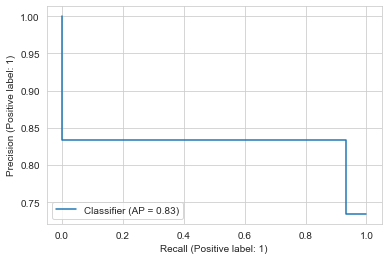

In [13]:
features = ['bin_no','drug_no', 'reject_no', 'correct_diagnosis', 'tried_and_failed', 'contraindication']

# Fit the whole data.
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=4)

model.fit(pa_df[features].values, pa_df['pa_approved'])

# make predictions for the whole data
y_pred = model.predict(pa_df[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for the whole data
accuracy = accuracy_score(pa_df['pa_approved'], predictions)
precision = precision_score(pa_df['pa_approved'], predictions)
recall = recall_score(pa_df['pa_approved'], predictions)
f1 = f1_score(pa_df['pa_approved'], predictions)
print("Validation Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_df['pa_approved'], predictions)

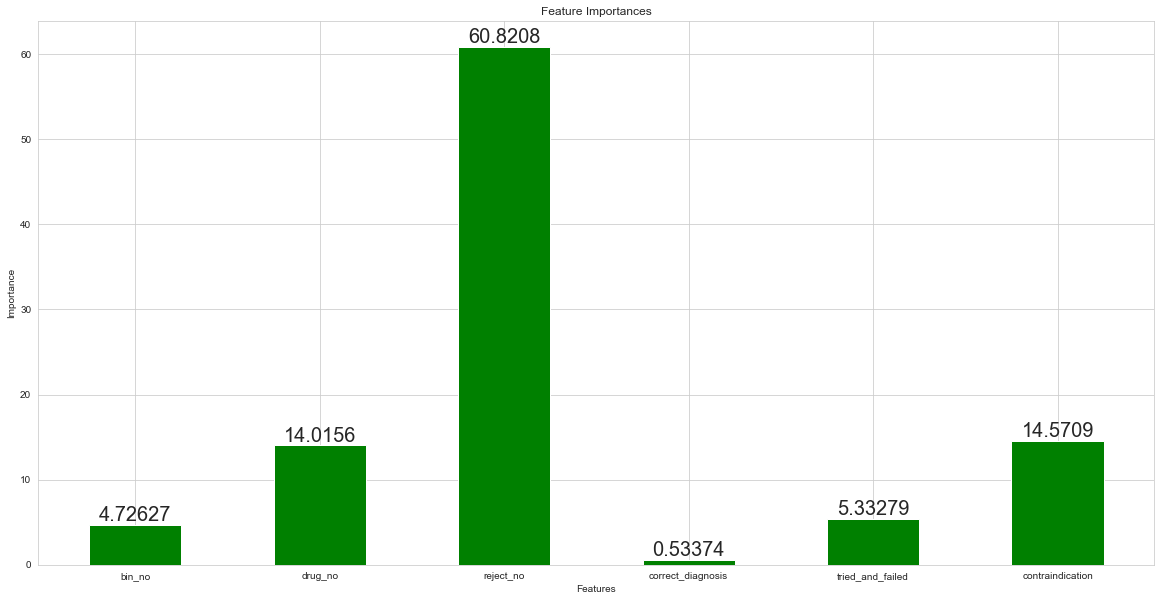

In [14]:
# Bar plot for the feature importances.

fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)

ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

0:	learn: 0.4193282	total: 74.3ms	remaining: 668ms
1:	learn: 0.3865564	total: 142ms	remaining: 569ms
2:	learn: 0.3781523	total: 212ms	remaining: 495ms
3:	learn: 0.3741564	total: 283ms	remaining: 424ms
4:	learn: 0.3727542	total: 363ms	remaining: 363ms
5:	learn: 0.3724715	total: 434ms	remaining: 289ms
6:	learn: 0.3718747	total: 511ms	remaining: 219ms
7:	learn: 0.3718461	total: 580ms	remaining: 145ms
8:	learn: 0.3717218	total: 652ms	remaining: 72.4ms
9:	learn: 0.3716591	total: 715ms	remaining: 0us
Validation Results:
Accuracy: 81.41%
Precision: 83.59%
Recall: 92.94%
f1: 88.02%


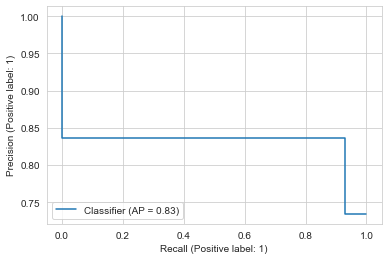

In [16]:
features = ['bin_no','drug_no', 'reject_no', 'correct_diagnosis', 'tried_and_failed', 'contraindication', 'is_weekday']

# Fit the whole data.
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=4)

model.fit(pa_df[features].values, pa_df['pa_approved'])

# make predictions for the whole data
y_pred = model.predict(pa_df[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for the whole data
accuracy = accuracy_score(pa_df['pa_approved'], predictions)
precision = precision_score(pa_df['pa_approved'], predictions)
recall = recall_score(pa_df['pa_approved'], predictions)
f1 = f1_score(pa_df['pa_approved'], predictions)
print("Validation Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_df['pa_approved'], predictions)

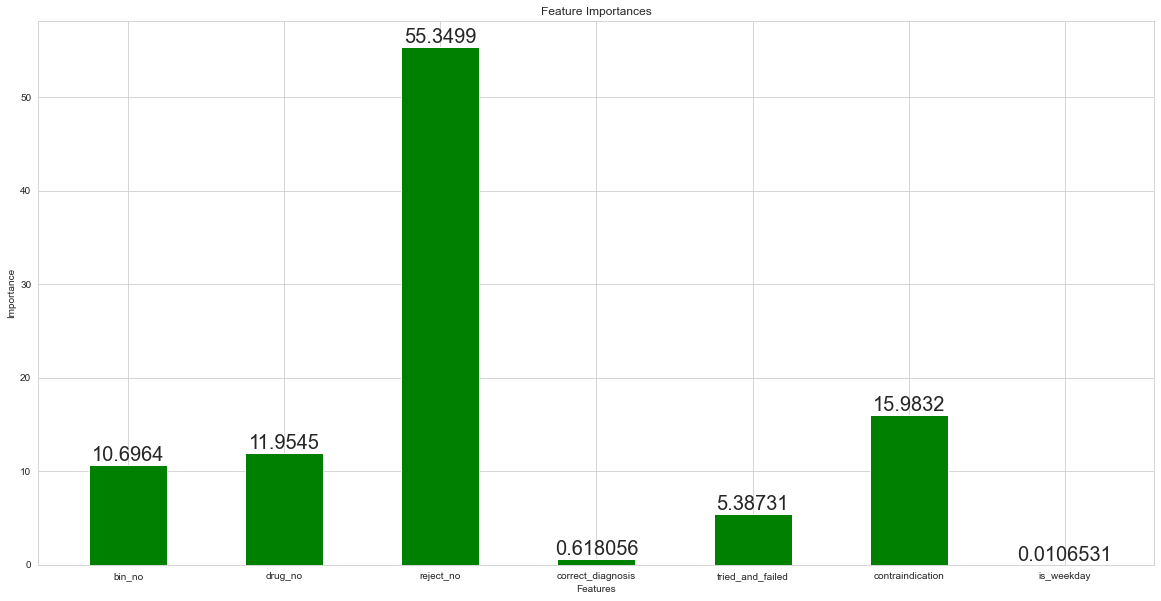

In [17]:
# Bar plot for the feature importances.

fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)

ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

0:	learn: 0.4193282	total: 61.7ms	remaining: 555ms
1:	learn: 0.3865564	total: 129ms	remaining: 518ms
2:	learn: 0.3781523	total: 190ms	remaining: 442ms
3:	learn: 0.3741564	total: 265ms	remaining: 398ms
4:	learn: 0.3727542	total: 339ms	remaining: 339ms
5:	learn: 0.3724715	total: 407ms	remaining: 271ms
6:	learn: 0.3718747	total: 478ms	remaining: 205ms
7:	learn: 0.3718461	total: 550ms	remaining: 137ms
8:	learn: 0.3717218	total: 616ms	remaining: 68.5ms
9:	learn: 0.3714733	total: 676ms	remaining: 0us
Validation Results:
Accuracy: 81.39%
Precision: 84.72%
Recall: 91.09%
f1: 87.79%


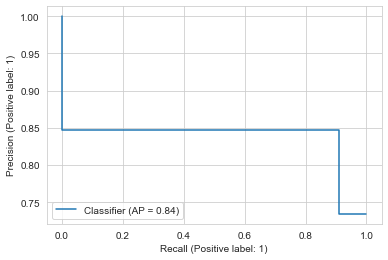

In [18]:
features = ['bin_no','drug_no', 'reject_no', 'correct_diagnosis', 'tried_and_failed', 'contraindication', 'is_holiday']

# Fit the whole data.
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=4)

model.fit(pa_df[features].values, pa_df['pa_approved'])

# make predictions for the whole data
y_pred = model.predict(pa_df[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for the whole data
accuracy = accuracy_score(pa_df['pa_approved'], predictions)
precision = precision_score(pa_df['pa_approved'], predictions)
recall = recall_score(pa_df['pa_approved'], predictions)
f1 = f1_score(pa_df['pa_approved'], predictions)
print("Validation Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_df['pa_approved'], predictions)

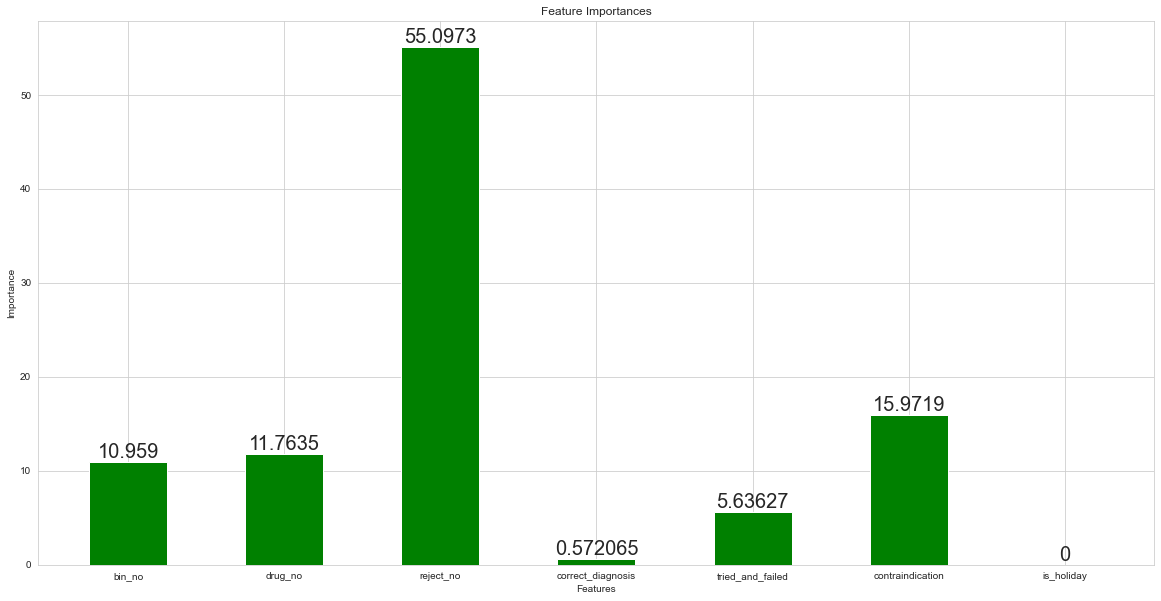

In [19]:
# Bar plot for the feature importances.

fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)

ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

0:	learn: 0.4193282	total: 61.7ms	remaining: 555ms
1:	learn: 0.3865564	total: 126ms	remaining: 505ms
2:	learn: 0.3781523	total: 190ms	remaining: 443ms
3:	learn: 0.3741564	total: 250ms	remaining: 375ms
4:	learn: 0.3727542	total: 319ms	remaining: 319ms
5:	learn: 0.3724715	total: 388ms	remaining: 259ms
6:	learn: 0.3718747	total: 453ms	remaining: 194ms
7:	learn: 0.3718461	total: 516ms	remaining: 129ms
8:	learn: 0.3717218	total: 578ms	remaining: 64.3ms
9:	learn: 0.3716564	total: 635ms	remaining: 0us
Validation Results:
Accuracy: 81.41%
Precision: 83.61%
Recall: 92.91%
f1: 88.01%


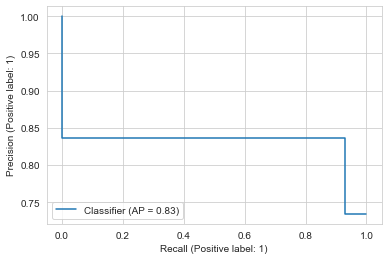

In [20]:
features = ['bin_no','drug_no', 'reject_no', 'correct_diagnosis', 'tried_and_failed', 'contraindication', 'is_workday']

# Fit the whole data.
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=4)

model.fit(pa_df[features].values, pa_df['pa_approved'])

# make predictions for the whole data
y_pred = model.predict(pa_df[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for the whole data
accuracy = accuracy_score(pa_df['pa_approved'], predictions)
precision = precision_score(pa_df['pa_approved'], predictions)
recall = recall_score(pa_df['pa_approved'], predictions)
f1 = f1_score(pa_df['pa_approved'], predictions)
print("Validation Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_df['pa_approved'], predictions)

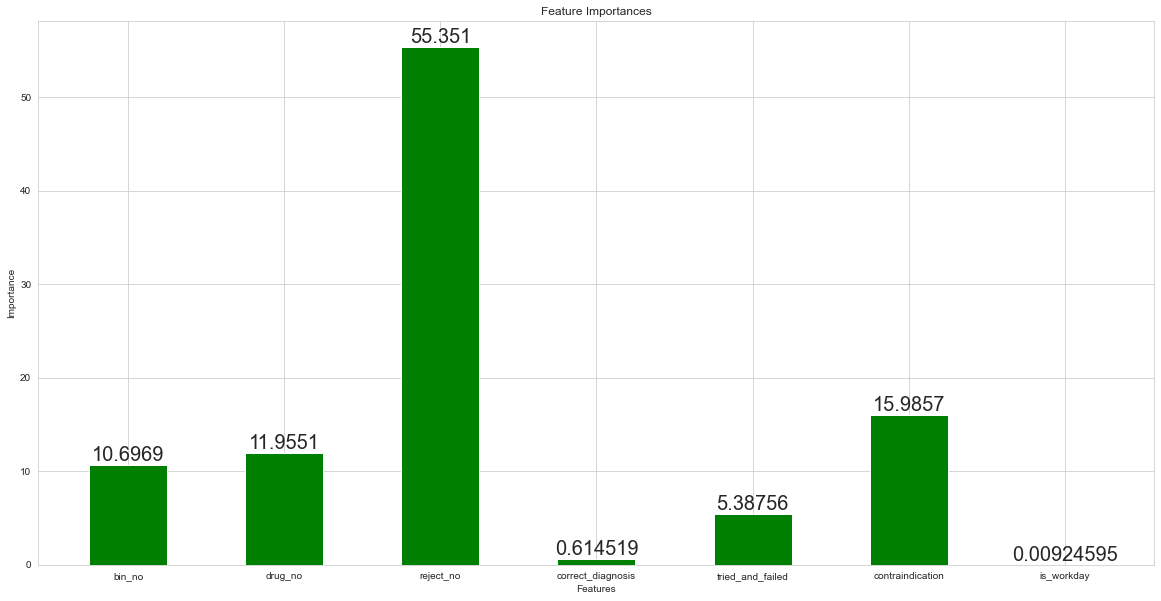

In [21]:
# Bar plot for the feature importances.

fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)

ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

0:	learn: 0.4193282	total: 64.8ms	remaining: 583ms
1:	learn: 0.3863525	total: 128ms	remaining: 512ms
2:	learn: 0.3776517	total: 194ms	remaining: 452ms
3:	learn: 0.3734960	total: 265ms	remaining: 398ms
4:	learn: 0.3729096	total: 340ms	remaining: 340ms
5:	learn: 0.3722397	total: 406ms	remaining: 271ms
6:	learn: 0.3718534	total: 472ms	remaining: 202ms
7:	learn: 0.3717490	total: 543ms	remaining: 136ms
8:	learn: 0.3715830	total: 607ms	remaining: 67.4ms
9:	learn: 0.3713458	total: 669ms	remaining: 0us
Validation Results:
Accuracy: 81.42%
Precision: 83.18%
Recall: 93.65%
f1: 88.10%


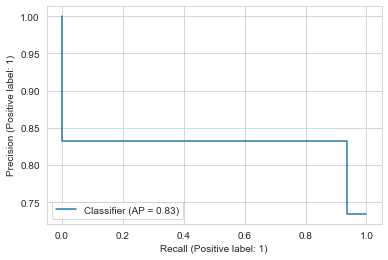

In [22]:
features = ['bin_no','drug_no', 'reject_no', 'correct_diagnosis', 'tried_and_failed', 'contraindication', 'day_of_week']

# Fit the whole data.
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=4)

model.fit(pa_df[features].values, pa_df['pa_approved'])

# make predictions for the whole data
y_pred = model.predict(pa_df[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for the whole data
accuracy = accuracy_score(pa_df['pa_approved'], predictions)
precision = precision_score(pa_df['pa_approved'], predictions)
recall = recall_score(pa_df['pa_approved'], predictions)
f1 = f1_score(pa_df['pa_approved'], predictions)
print("Validation Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_df['pa_approved'], predictions)

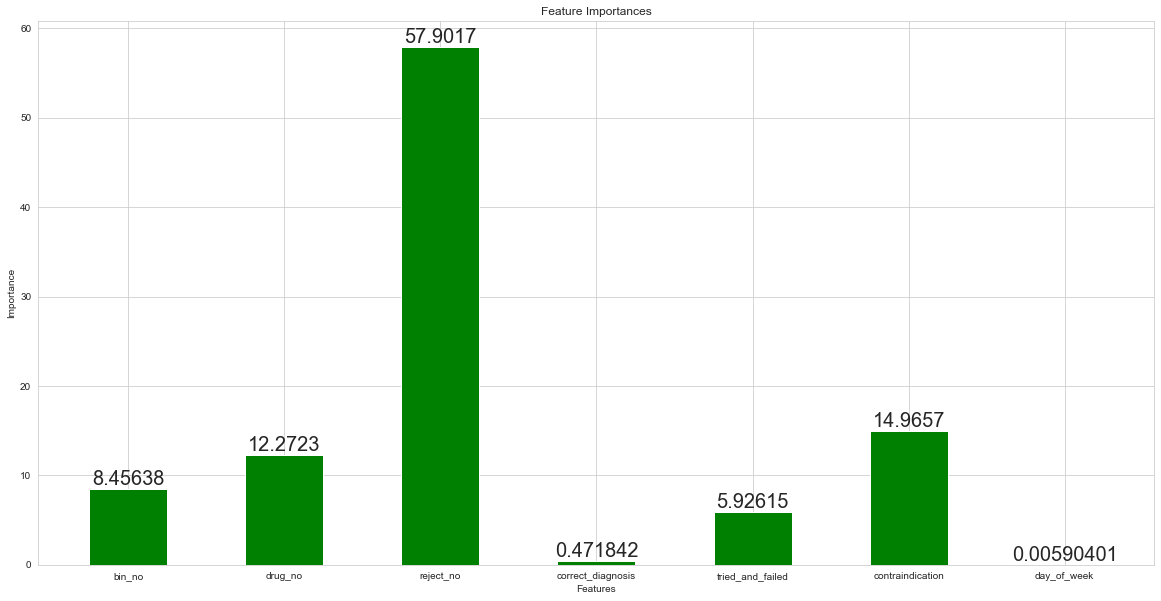

In [23]:
# Bar plot for the feature importances.

fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)

ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

We see the importance of date data is negligible, and adding them decreases the f1 sore, so we will not use date data in our predictions. This makes sense, as whether a PA claim is approved or rejected is independen of the time the claim is made.